# Check data leak

Train data in validation or test

In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

from pathlib import Path
import sys
sys.path.insert(0, Path(".").absolute().parent.as_posix())

import numpy as np
import pandas as pd

import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline

from common.dataset import FilesFromCsvDataset, TrainvalFilesDataset, TransformedDataset, read_image, TestFilesDataset

In [2]:
train_dataset = TrainvalFilesDataset("/home/fast_storage/imaterialist-challenge-furniture-2018/train")
train_img_dataset = TransformedDataset(train_dataset, transforms=lambda x: read_image(x), target_transforms=lambda y: y - 1)

val_dataset = TrainvalFilesDataset("/home/fast_storage/imaterialist-challenge-furniture-2018/validation")
val_img_dataset = TransformedDataset(val_dataset, transforms=lambda x: read_image(x), target_transforms=lambda y: y - 1)

test_dataset = TestFilesDataset("/home/fast_storage/imaterialist-challenge-furniture-2018/test")
test_img_dataset = TransformedDataset(test_dataset, transforms=lambda x: read_image(x))

In [17]:
import hashlib

In [23]:
from PIL import Image
from tqdm import tqdm

def get_label_size_hash(dataset, has_labels=True):
    sizes= [None] * len(dataset)
    y = [None] * len(dataset)
    hashes = [None] * len(dataset)

    for i, dp in enumerate(tqdm(dataset)):
        img = read_image(dp[0])
        sizes[i] = img.size
        hashes[i] = hashlib.md5(img.tobytes()).hexdigest()
        if has_labels:
            y[i] = dp[1]
    df = pd.DataFrame({"width": np.array(sizes)[:, 0], "height": np.array(sizes)[:, 1], "label": y, "hash": hashes})
    return df

In [38]:
train_df = get_label_size_hash(train_dataset)

100%|██████████| 191260/191260 [1:02:13<00:00, 51.22it/s]


In [26]:
val_df = get_label_size_hash(val_dataset)

100%|██████████| 6300/6300 [02:14<00:00, 46.85it/s]


In [28]:
test_df = get_label_size_hash(test_dataset, has_labels=False)

100%|██████████| 12665/12665 [04:38<00:00, 45.54it/s]


In [8]:
train_df.head()

height  label  width
0     715      9   1432
1     800     44    800
2     375     92    500
3     800     53    800
4     300     16    450

In [40]:
train_df.head()

hash  height  label  width
0  90c19f0aa2dc0775b5ac68236a87558b     715      9   1432
1  a99e0ada67b903d62bc33012bdd28337     800     44    800
2  98f54289ae539d4c3e3c80548c67ff0c     375     92    500
3  4b2a237a1e32ea990fe7b9cd64aff988     800     53    800
4  9c30fd63429ef428f3c94aca9a7e37cc     300     16    450

In [27]:
val_df.head()

hash  height  label  width
0  a1ae8bad98410739930b9ffe5be9c217     800     48    800
1  b9767a12de680a379eedd9b34fb0e3b9     550     79    730
2  11beee2ff1a1db86d58b8dca30fe7349     800    119    800
3  7da3698f711820ac7260fd7f85627745     480     27    640
4  8ba2317291fa7c80f83bbdb9dd7eab8e     800     22    800

In [29]:
test_df.head()

hash  height label  width
0  041d57f9cf15805c0584126d3affd3af     750  None    750
1  d8c85ebbc511cdb71e623c25b94fba4f     722  None    889
2  6ea0cbcad953271ea7eec1aa4b7110b7     800  None    800
3  b7570135735ed3f84956e5b21c59dd85     500  None    500
4  269bcb6b0c113ae3328782313328645e     800  None    800

In [185]:
train_files = [None] * len(train_dataset)

for i, dp in enumerate(train_dataset):
    train_files[i] = dp[0]

train_df.loc[:, 'filename'] = train_files

In [186]:
val_files = [None] * len(val_dataset)

for i, dp in enumerate(val_dataset):
    val_files[i] = dp[0]

val_df.loc[:, 'filename'] = val_files

In [176]:
test_ids = [None] * len(test_dataset)

for i, dp in enumerate(test_dataset):
    test_ids[i] = dp[1]

test_df.loc[:, 'id'] = test_ids

In [187]:
train_df.head()

hash  height  label  width  \
0  90c19f0aa2dc0775b5ac68236a87558b     715      9   1432   
1  a99e0ada67b903d62bc33012bdd28337     800     44    800   
2  98f54289ae539d4c3e3c80548c67ff0c     375     92    500   
3  4b2a237a1e32ea990fe7b9cd64aff988     800     53    800   
4  9c30fd63429ef428f3c94aca9a7e37cc     300     16    450   

                                            filename  
0  /home/fast_storage/imaterialist-challenge-furn...  
1  /home/fast_storage/imaterialist-challenge-furn...  
2  /home/fast_storage/imaterialist-challenge-furn...  
3  /home/fast_storage/imaterialist-challenge-furn...  
4  /home/fast_storage/imaterialist-challenge-furn...

Save results:

In [188]:
train_df.to_csv("train_df.csv", index=False)
val_df.to_csv("val_df.csv", index=False)
test_df.to_csv("test_df.csv", index=False)

Compare hashes

In [41]:
len(train_df['hash'].unique()), len(train_df['hash'])

(184909, 191260)

In [34]:
len(val_df['hash'].unique()), len(val_df['hash'])

(6278, 6300)

In [35]:
len(test_df['hash'].unique()), len(test_df['hash'])

(12594, 12665)

In [43]:
len(set(train_df['hash'].unique()) & set(val_df['hash'].unique()))

404

In [37]:
len(set(val_df['hash'].unique()) & set(test_df['hash'].unique()))

60

In [42]:
len(set(train_df['hash'].unique()) & set(test_df['hash'].unique()))

764

In [179]:
len((set(train_df['hash'].unique()) & set(test_df['hash'].unique())) | (set(val_df['hash'].unique()) & set(test_df['hash'].unique())))

789

Remove duplicates from the train

In [115]:
train_df.head()

hash  height  label  width
0  90c19f0aa2dc0775b5ac68236a87558b     715      9   1432
1  a99e0ada67b903d62bc33012bdd28337     800     44    800
2  98f54289ae539d4c3e3c80548c67ff0c     375     92    500
3  4b2a237a1e32ea990fe7b9cd64aff988     800     53    800
4  9c30fd63429ef428f3c94aca9a7e37cc     300     16    450

In [189]:
duplicates = train_df['hash'].duplicated(keep=False)

In [193]:
train_df = train_df[~duplicates]

In [205]:
train_df.shape

(180517, 5)

In [196]:
filtered_train_df = pd.read_csv("../output/filtered_train_dataset.csv")

In [199]:
filtered_train_df.shape

(191020, 2)

In [201]:
mask = filtered_train_df['filepath'].isin(train_df['filename'])

In [202]:
filtered_train_df = filtered_train_df[mask]

In [203]:
filtered_train_df.shape

(180505, 2)

In [207]:
filtered_train_df.to_csv("../output/unique_filtered_train_dataset.csv", index=False)

Remove duplicates from the validation

In [211]:
val_df.head()

hash  height  label  width  \
0  a1ae8bad98410739930b9ffe5be9c217     800     48    800   
1  b9767a12de680a379eedd9b34fb0e3b9     550     79    730   
2  11beee2ff1a1db86d58b8dca30fe7349     800    119    800   
3  7da3698f711820ac7260fd7f85627745     480     27    640   
4  8ba2317291fa7c80f83bbdb9dd7eab8e     800     22    800   

                                            filename  
0  /home/fast_storage/imaterialist-challenge-furn...  
1  /home/fast_storage/imaterialist-challenge-furn...  
2  /home/fast_storage/imaterialist-challenge-furn...  
3  /home/fast_storage/imaterialist-challenge-furn...  
4  /home/fast_storage/imaterialist-challenge-furn...

In [212]:
duplicates = val_df['hash'].duplicated(keep=False)

In [213]:
val_df = val_df[~duplicates]

In [214]:
val_df.shape

(6263, 5)

In [215]:
filtered_val_df = pd.read_csv("../output/filtered_val_dataset.csv")

In [217]:
filtered_val_df.shape

(6291, 2)

In [218]:
mask = filtered_val_df['filepath'].isin(val_df['filename'])

filtered_val_df = filtered_val_df[mask]

In [219]:
filtered_val_df.shape

(6263, 2)

In [220]:
filtered_val_df.to_csv("../output/unique_filtered_val_dataset.csv", index=False)

Save the data leak in CSV

In [180]:
common_hashes = list((set(train_df['hash'].unique()) & set(test_df['hash'].unique())) | (set(val_df['hash'].unique()) & set(test_df['hash'].unique())))

In [181]:
test_with_labels_df = test_df.copy()
test_with_labels_df.loc[:, 'label'] = -1

In [182]:
def get_label(h):
    train_label = set(train_df[train_df['hash'] == h]['label'].values)
    if len(train_label) > 1:
        print("Train hash {} has labels: {}".format(h, train_label))
        return -1
    val_label = set(val_df[val_df['hash'] == h]['label'].values)
    if len(val_label) > 1:
        print("Val hash {} has labels: {}".format(h, val_label))
        return -1
    if len(train_label) > 0 and len(val_label) > 0:
        if train_label != val_label:
            print("{} : {} vs {}".format(h, train_label, val_label))
    label = train_label.pop() if len(train_label) > 0 else val_label.pop()
    return label


for h in common_hashes:
    test_with_labels_df.loc[test_with_labels_df['hash'] == h, 'label'] = get_label(h)

Train hash 33996b35bcc422707b5fbb0a8526d865 has labels: {108, 5}
Train hash ad31a1af96e50288691dcde4fdf14a1f has labels: {32, 66}
Train hash 5558f44507774425f03c9e3d794c4611 has labels: {128, 19}
Train hash 27756c5bded9d1ca4d97ff2abd526fe3 has labels: {98, 100, 5, 43, 13, 112, 17, 23, 120, 59}
Train hash 22f9627ad205da6f40cb207f3ce04962 has labels: {105, 60}
Train hash 7d856c37bab58cfcf154baa820a48501 has labels: {109, 39}
Train hash 8597d4e7e65352a302b63e07bc01a7da has labels: {2, 3, 6, 8, 11, 13, 15, 17, 18, 20, 24, 25, 26, 28, 29, 31, 34, 35, 37, 39, 41, 42, 43, 46, 47, 48, 49, 50, 51, 55, 56, 58, 59, 60, 61, 62, 63, 64, 65, 66, 70, 71, 73, 75, 76, 79, 85, 88, 90, 92, 94, 95, 97, 98, 99, 102, 103, 104, 105, 106, 107, 110, 111, 114, 115, 117, 119, 120, 121, 122, 123, 125, 126, 127}
Train hash 6da3d4a6d753fdc930bd9cc30e0afff2 has labels: {128, 36, 69, 42, 107, 45, 80, 17, 116, 56, 89, 126}
Train hash 08b16983f9b46bfe27c5084aed975057 has labels: {4, 29}
Train hash 097e08a39a7cab0a1c6ce

In [183]:
test_with_labels_df.head(10)

hash  height  label  width     id
0  041d57f9cf15805c0584126d3affd3af     750     -1    750   2823
1  d8c85ebbc511cdb71e623c25b94fba4f     722     -1    889   4204
2  6ea0cbcad953271ea7eec1aa4b7110b7     800     -1    800   8125
3  b7570135735ed3f84956e5b21c59dd85     500     -1    500   1485
4  269bcb6b0c113ae3328782313328645e     800      5    800  11402
5  2b3493c34bf1d32e3f9644097943c92d     800     -1    800   1851
6  96a37345fd420188753e21b080e656c1     768     -1   1024  10327
7  a022eef416e3af4c9f67a17639223b0d     819     -1   1000   9963
8  a2209486793ace4925c14b5239d2af6a    1200     -1   1200   7537
9  3eebf51bfd39e64638a983d101f20e6b     266     -1    355   3765

In [184]:
test_with_labels_df.to_csv("test_with_labels.csv", index=False)

## Visual check of identical images - Train dataset

In [134]:
gb = train_df.groupby('hash')

In [135]:
hash_count = gb['hash'].count()
non_unique_hash = hash_count[hash_count > 1]

In [136]:
hash_count.max(), hash_count.min(), len(non_unique_hash.index)

(187, 1, 4392)

In [97]:
hash_count.describe()

count    184909.000000
mean          1.034347
std           0.514131
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         187.000000
Name: hash, dtype: float64

Number of identical images: 2
Number of identical images: 3
Number of identical images: 5
Number of identical images: 4
Number of identical images: 3
Number of identical images: 2
Number of identical images: 2
Number of identical images: 2
Number of identical images: 2
Number of identical images: 2


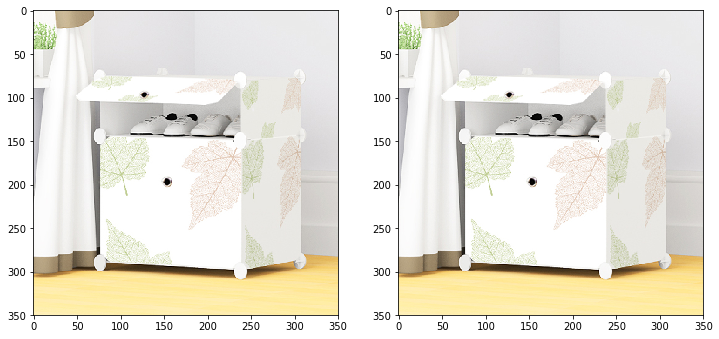

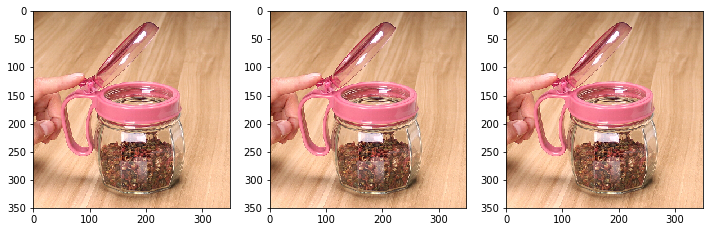

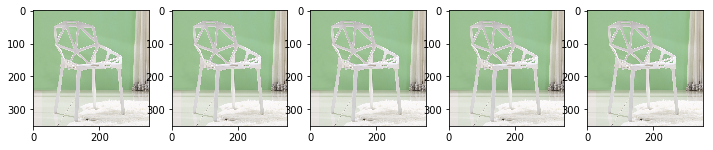

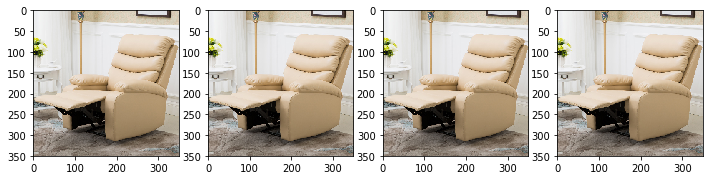

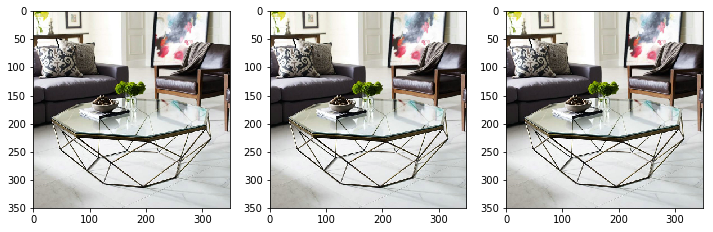

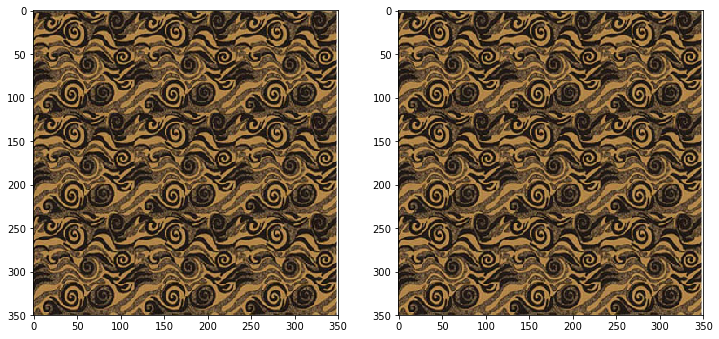

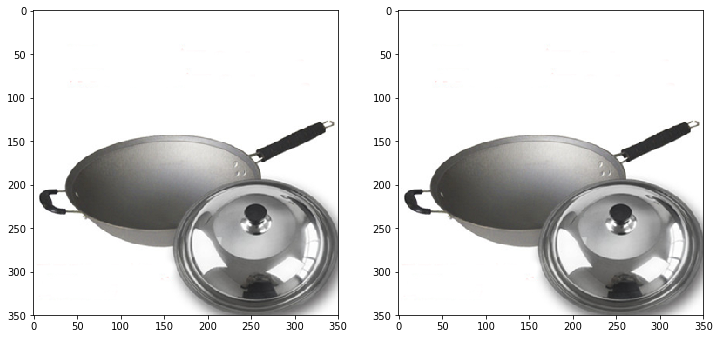

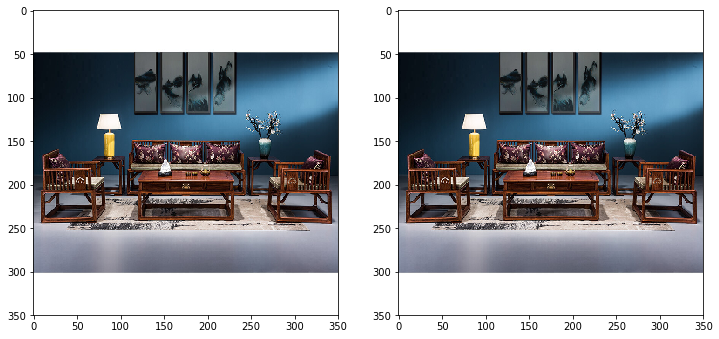

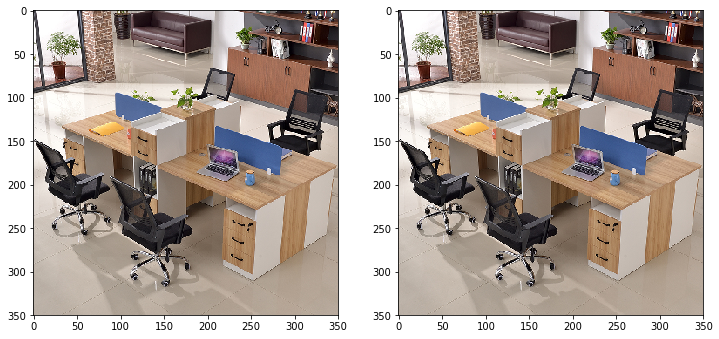

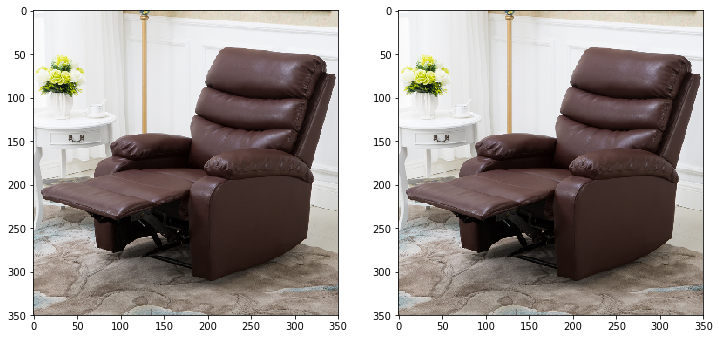

In [94]:
n = min(10, len(non_unique_hash.index))
for i in range(n):
    same_image_indices = gb.get_group(non_unique_hash.index[i]).index.values
    plt.figure(figsize=(12, 7))
    print("Number of identical images: {}".format(len(same_image_indices)))
    m = min(5, len(same_image_indices))
    for j, index in enumerate(same_image_indices[:m]):
        img = train_img_dataset[index][0].resize((350, 350))
        plt.subplot(1, m, j + 1)
        plt.imshow(img)

Show max duplicated image:

Number of identical images: 187


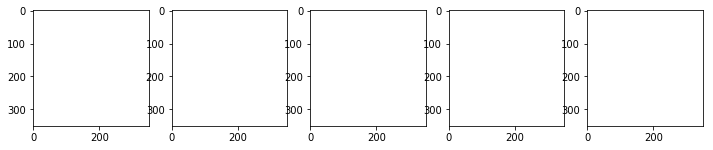

In [100]:
max_count_img_index = non_unique_hash[non_unique_hash == non_unique_hash.max()].index[0]

same_image_indices = gb.get_group(max_count_img_index).index.values
plt.figure(figsize=(12, 7))
print("Number of identical images: {}".format(len(same_image_indices)))
m = min(5, len(same_image_indices))
for j, index in enumerate(same_image_indices[:m]):
    img = train_img_dataset[index][0].resize((350, 350))
    plt.subplot(1, m, j + 1)
    plt.imshow(img)

Number of identical images: 7


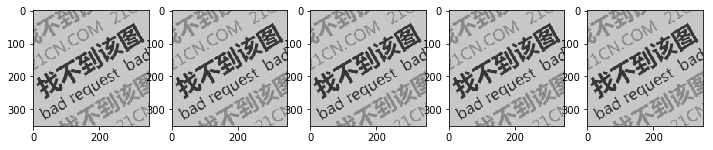

In [143]:
same_image_indices = gb.get_group("6ba32b54d92f60a9639a793f99cff202").index.values
plt.figure(figsize=(12, 7))
print("Number of identical images: {}".format(len(same_image_indices)))
m = min(5, len(same_image_indices))
for j, index in enumerate(same_image_indices[:m]):
    img = train_img_dataset[index][0].resize((350, 350))
    plt.subplot(1, m, j + 1)
    plt.imshow(img)

## Visual check of identical images - Val dataset

In [144]:
gb = val_df.groupby('hash')

In [145]:
hash_count = gb['hash'].count()
non_unique_hash = hash_count[hash_count > 1]

In [146]:
hash_count.max(), hash_count.min(), len(non_unique_hash.index)

(9, 1, 15)

In [104]:
hash_count.describe()

count    6278.000000
mean        1.003504
std         0.111418
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         9.000000
Name: hash, dtype: float64

Number of identical images: 2
Number of identical images: 2
Number of identical images: 2
Number of identical images: 2
Number of identical images: 2
Number of identical images: 9
Number of identical images: 2
Number of identical images: 2
Number of identical images: 2
Number of identical images: 2


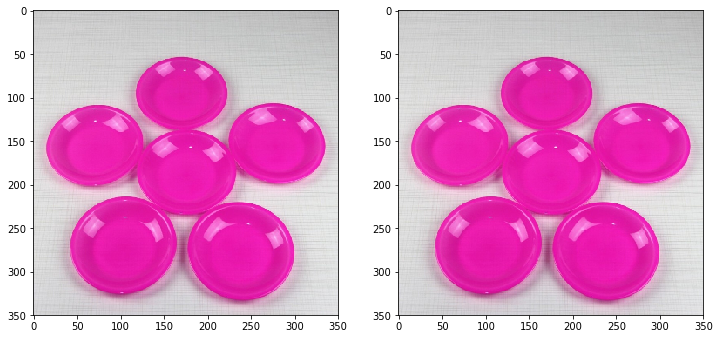

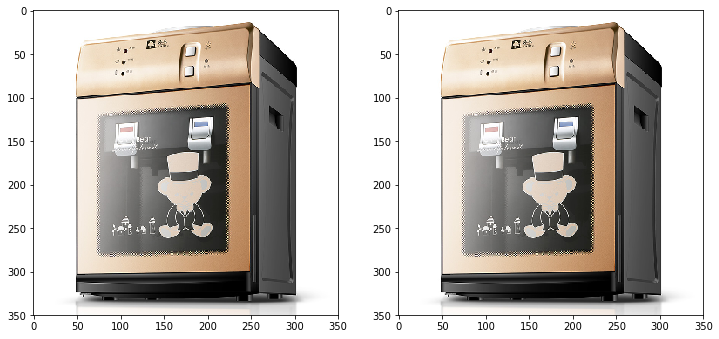

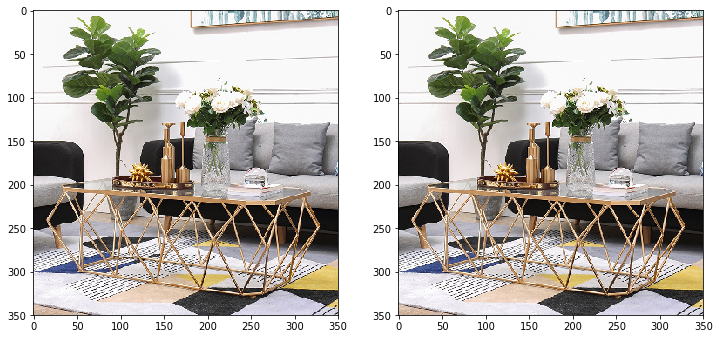

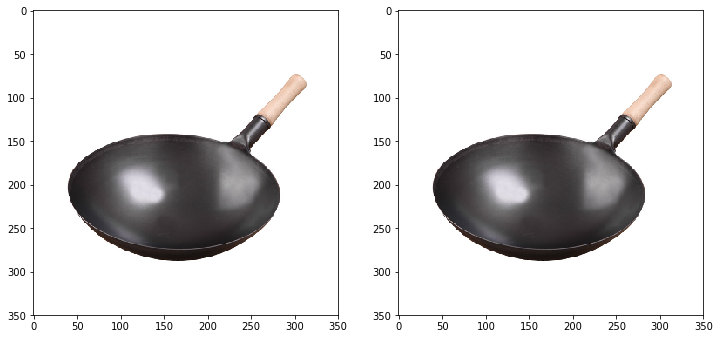

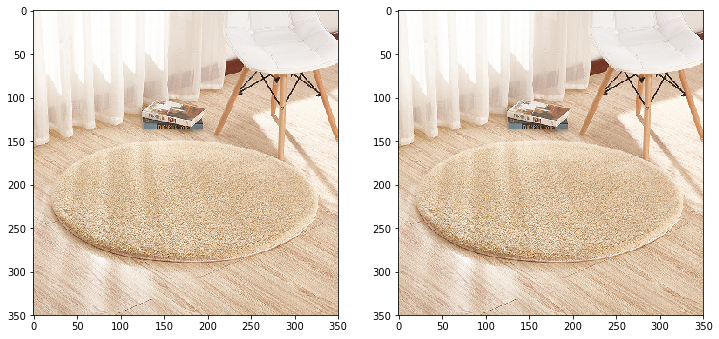

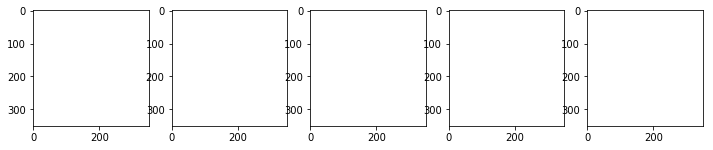

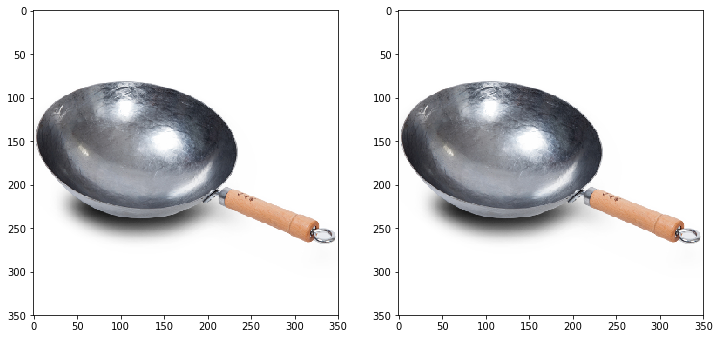

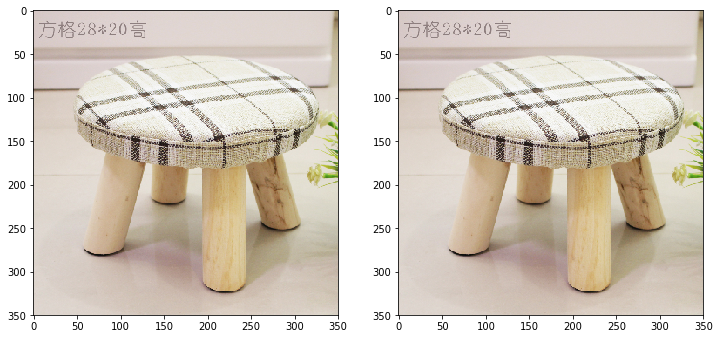

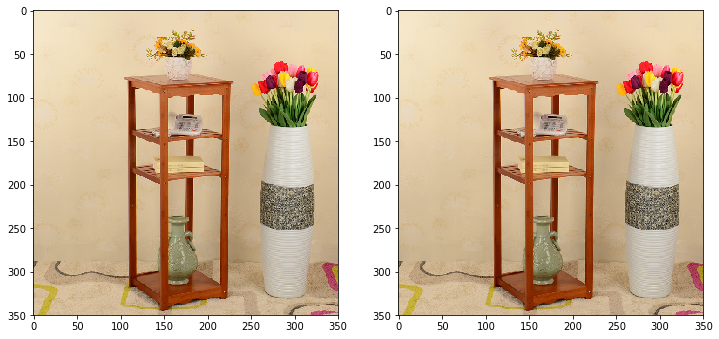

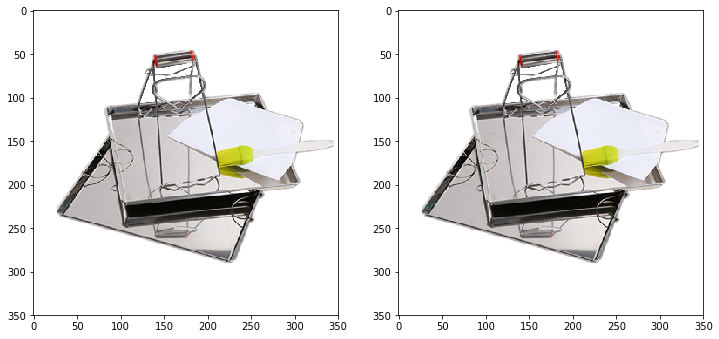

In [107]:
n = min(10, len(non_unique_hash.index))
for i in range(n):
    same_image_indices = gb.get_group(non_unique_hash.index[i]).index.values
    plt.figure(figsize=(12, 7))
    print("Number of identical images: {}".format(len(same_image_indices)))
    m = min(5, len(same_image_indices))
    for j, index in enumerate(same_image_indices[:m]):
        img = val_img_dataset[index][0].resize((350, 350))
        plt.subplot(1, m, j + 1)
        plt.imshow(img)

Show max duplicated image:

Number of identical images: 9


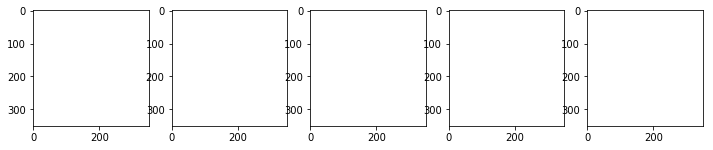

In [108]:
max_count_img_index = non_unique_hash[non_unique_hash == non_unique_hash.max()].index[0]

same_image_indices = gb.get_group(max_count_img_index).index.values
plt.figure(figsize=(12, 7))
print("Number of identical images: {}".format(len(same_image_indices)))
m = min(5, len(same_image_indices))
for j, index in enumerate(same_image_indices[:m]):
    img = val_img_dataset[index][0].resize((350, 350))
    plt.subplot(1, m, j + 1)
    plt.imshow(img)

Number of identical images: 9


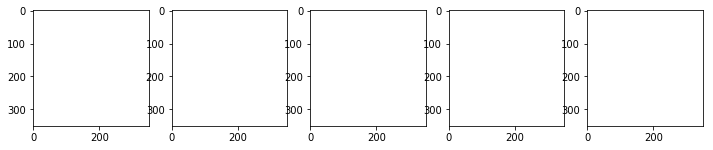

In [147]:
same_image_indices = gb.get_group("8597d4e7e65352a302b63e07bc01a7da").index.values
plt.figure(figsize=(12, 7))
print("Number of identical images: {}".format(len(same_image_indices)))
m = min(5, len(same_image_indices))
for j, index in enumerate(same_image_indices[:m]):
    img = val_img_dataset[index][0].resize((350, 350))
    plt.subplot(1, m, j + 1)
    plt.imshow(img)

## Visual check of identical images - Test dataset

In [195]:
gb = test_df.groupby('hash')

In [110]:
hash_count = gb['hash'].count()
non_unique_hash = hash_count[hash_count > 1]

In [111]:
hash_count.max(), hash_count.min(), len(non_unique_hash.index)

(11, 1, 52)

In [112]:
hash_count.describe()

count    12594.000000
mean         1.005638
std          0.123670
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         11.000000
Name: hash, dtype: float64

Number of identical images: 2
Number of identical images: 2
Number of identical images: 2
Number of identical images: 2
Number of identical images: 2
Number of identical images: 2
Number of identical images: 2
Number of identical images: 2
Number of identical images: 2
Number of identical images: 2


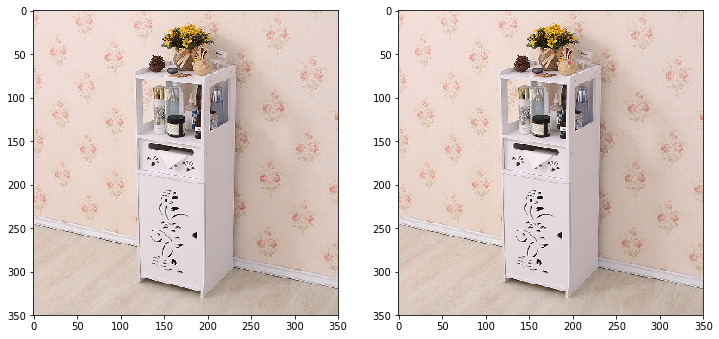

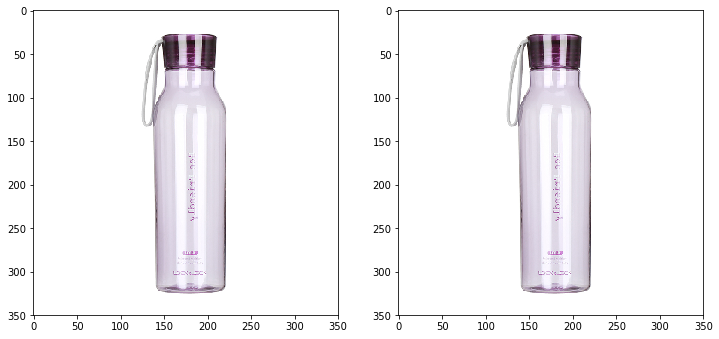

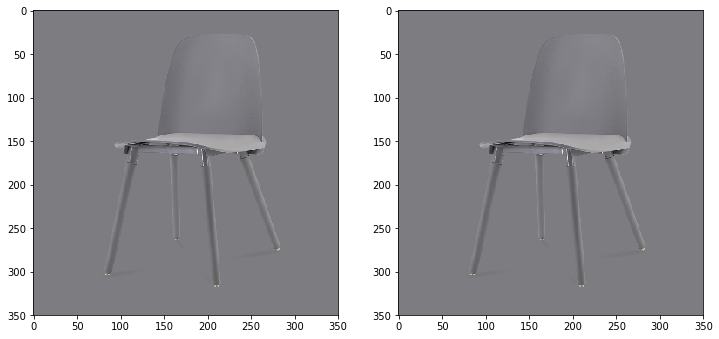

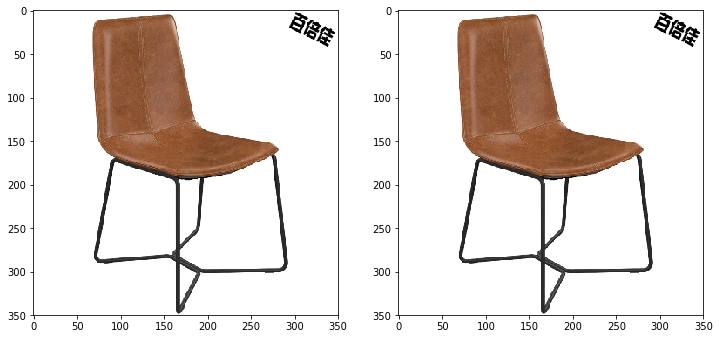

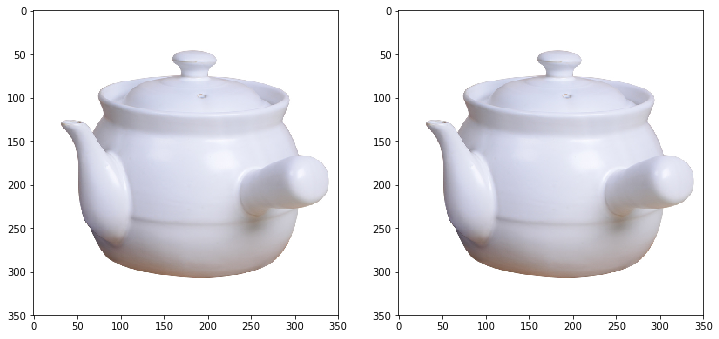

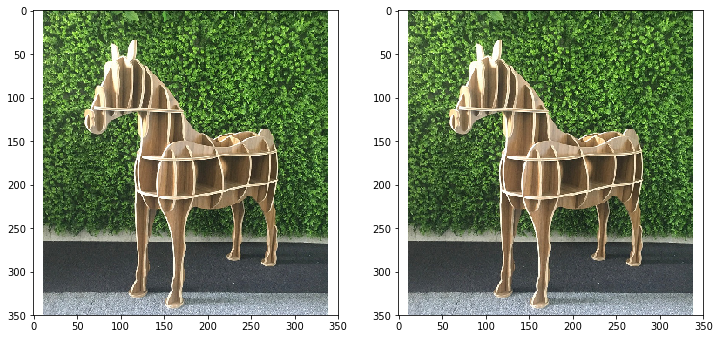

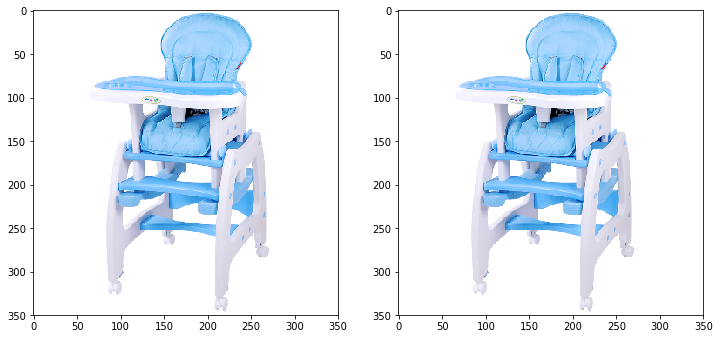

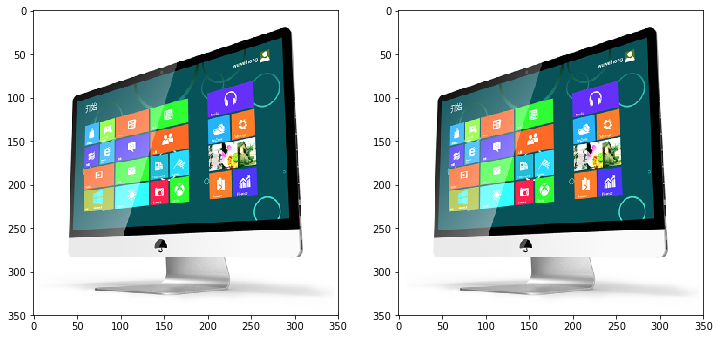

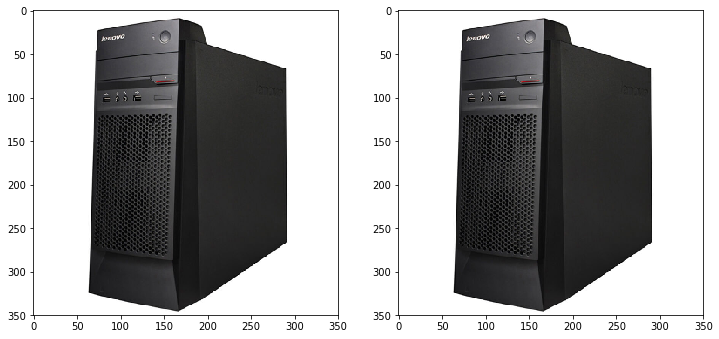

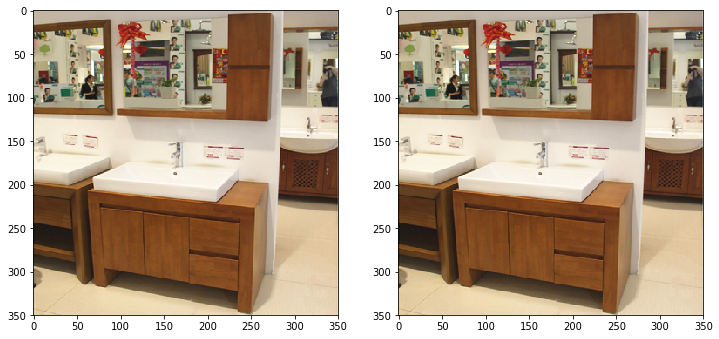

In [113]:
n = min(10, len(non_unique_hash.index))
for i in range(n):
    same_image_indices = gb.get_group(non_unique_hash.index[i]).index.values
    plt.figure(figsize=(12, 7))
    print("Number of identical images: {}".format(len(same_image_indices)))
    m = min(5, len(same_image_indices))
    for j, index in enumerate(same_image_indices[:m]):
        img = test_img_dataset[index][0].resize((350, 350))
        plt.subplot(1, m, j + 1)
        plt.imshow(img)

Show max duplicated image:

Number of identical images: 11


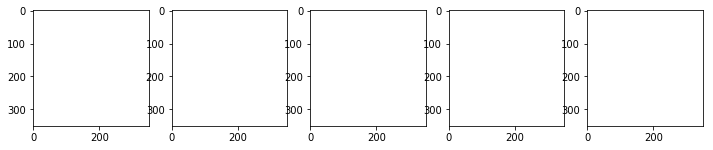

In [114]:
max_count_img_index = non_unique_hash[non_unique_hash == non_unique_hash.max()].index[0]

same_image_indices = gb.get_group(max_count_img_index).index.values
plt.figure(figsize=(12, 7))
print("Number of identical images: {}".format(len(same_image_indices)))
m = min(5, len(same_image_indices))
for j, index in enumerate(same_image_indices[:m]):
    img = test_img_dataset[index][0].resize((350, 350))
    plt.subplot(1, m, j + 1)
    plt.imshow(img)